# Simulation of Flexible Vehicle Routing

In [415]:
#TODO: Fix alt method so that it doesn't send out truck if primary route already covered by previous truck

## A. Setup

In [20]:
import sys
import numpy as np
import pandas as pd
import math
import random
import time
import matplotlib.pyplot as plt
#from concorde.tsp import TSPSolver
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
print(sys.version)

3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]


In [9]:
# GLOBAL VARIABLES
field_width = 100 # Customer location has x-coordinate in (0, field_width)
field_height = 100 # Customer location has y-coordinate in (0, field_height)
depot_x = 50 # Depot x-coordinate
depot_y = 50 # Depot y-coordinate

## B. Classes and methods

### Instance class for random demands and locations

In [10]:
class Instance():
    """A realized set of node locations and demands and the resulting routing characteristics."""
    def __init__(self, xlocs, ylocs, demands, solve_TSP=True):

        self.size = len(demands)-1
        self.demands = demands
        self.xlocs = xlocs
        self.ylocs = ylocs
        self.distances = self.calc_distance_matrix()
        self.optimal_routes = 'None'
        self.tour = 'None'
        if solve_TSP:
            #self.tour = self.solve_TSP()
            self.tour = self.nearest_neighbor()
            
    def calc_distance_matrix(self):
        """Returns a matrix with pairwise node distances"""
        distances = np.zeros((self.size+1, self.size+1), dtype=float)
        for i in range(self.size+1):
            for j in range(self.size+1):
                new_dist = math.sqrt((self.xlocs[i]-self.xlocs[j])**2 + (self.ylocs[i]-self.ylocs[j])**2)
                distances[i,j] = new_dist
        return distances

    def update_demands(self, demands):
        self.demands = demands
    
    def update_tour(self, tour):
        self.tour = tour
        
    def get_lowerbound(self, capacity):
        """Returns a theoretical lowerbound on the optimal routing cost"""
        return (2/capacity) * sum([self.demands[i]*self.distances[0,i]
                                        for i in range(len(self.demands))])
    
    def get_fleet_size(self, route_size):
        """Returns the number of vehicles needed to visit all nodes given a fixed route size"""
        assert self.size % route_size == 0, "Number of customers must be evenly divisible by the route size."
        return int(self.size / route_size)
    
    def nearest_neighbor(self):

        # Tracker for whether a customer has been visited
        isVisited = dict([(c, False) for c in range(1,self.size+1)])

        # Begin tour at depot
        current = 0
        tour = [current]

        while not all(isVisited[i] == True for i in isVisited):

            # Find current customer's nearest neighbor (nn) and update tour
            candidate_distances = dict([(c, self.distances[current, c]) for c in isVisited if isVisited[c] == False])
            print candidate_distances
            nn = min(candidate_distances, key = candidate_distances.get)
            tour.append(nn)
            isVisited[nn] = True

        return tour

    def solve_TSP(self):
        """Defines and returns the TSP tour through all node locations"""
        solver = TSPSolver.from_data(self.xlocs, self.ylocs, 'EUC_2D')
        solution = solver.solve()
        self.tour = list(solution.tour)
        return self.tour
    
    def save_optimal_routes(self, route_list):
        self.optimal_routes = route_list

### Cost measures

In [11]:
def get_trip_count(route_list):
    """Returns number of trips in route list"""
    assert type(route_list[0]) == list, "route_list must be a list of lists (routes)"
    count = 0
    for route in route_list:
        if route != []:
            count += 1
    return count
    
def get_circular_cost(inst,segment):
    """Returns the total distance of moving from node to node within the given segment"""
    if len(segment) == 0:
        return 0
    else:
        return sum([inst.distances[segment[i],segment[i+1]] for i in range(len(segment)-1)])

def get_radial_cost(inst,segment):
    """Returns the total distance of trips to/from the depot at segment endpoints."""
    if len(segment) == 0:
        return 0
    else:
        return inst.distances[0,segment[0]] + inst.distances[0,segment[-1]]

def get_total_cost(inst,segment):
    """Returns sum of circular and radial costs for the given segment"""
    return get_circular_cost(inst,segment)+get_radial_cost(inst,segment)

### VRP heuristic
Using Google OR-Tools.

In [12]:
def solve_VRP(inst, capacity):

    def create_data_model(inst, capacity):
        data = {}
        data['distance_matrix'] = inst.distances
        data['demands'] = inst.demands
        data['vehicle_capacities'] = [capacity]*inst.size
        data['num_vehicles'] = inst.size
        data['depot'] = 0
        return data

    def get_routes(solution, routing, manager):
        """Get vehicle routes from a solution and store them in an array."""
        # Get vehicle routes and store them in a two dimensional array whose
        # i,j entry is the jth location visited by vehicle i along its route.
        routes = []
        for route_nbr in range(routing.vehicles()):
            index = routing.Start(route_nbr)
            route = [manager.IndexToNode(index)]
            while not routing.IsEnd(index):
                index = solution.Value(routing.NextVar(index))
                route.append(manager.IndexToNode(index))
            routes.append(route)
        return routes

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    
    
    # --- RUN PROGRAM ---

    # Zero cost if no demands
    if all(dem == 0 for dem in inst.demands):
        return (0, 0, 0)
    
    # Set up data model
    data = create_data_model(inst, capacity)
    
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    
    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add capacity constraint
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)
    all_routes = get_routes(solution, routing, manager)
    nonempty_routes = [route for route in all_routes if not all(i == 0 for i in route)]
    
    # Remove the depot from the optimal routes
    #parsed_routes = [route[1:-1] for route in nonempty_routes]
    #return parsed_routes
    
    return solution.ObjectiveValue(), len(nonempty_routes)  # returns (optimal cost, number of trips)

def solve_SDVRP(inst,capacity):
    """Creates equivalent demand/location instance with unit demand and solves the VRP with splittable demands"""
    split_xlocs = [[0]] + [[inst.xlocs[i]]*inst.demands[i] for i in range(1,len(inst.demands))]
    split_ylocs = [[0]] + [[inst.ylocs[i]]*inst.demands[i] for i in range(1,len(inst.demands))]
    split_demands = [[0]] + [[1]*inst.demands[i] for i in range(1,len(inst.demands))]

    split_xlocs = [v for sublist in split_xlocs for v in sublist]
    split_ylocs = [v for sublist in split_ylocs for v in sublist]
    split_demands = [v for sublist in split_demands for v in sublist]
    split_inst = Instance(split_xlocs, split_ylocs, split_demands)

    return solve_VRP(split_inst, capacity)

### Routing algorithms and helper methods

Create skeleton (a priori) routes

In [13]:
def get_primary_routes(inst, route_size):
    """Splits customer sequence into segments of 'route_size' number of customers"""
    
    tour =  inst.tour[1:] # Exclude depot
    routes = []
    for i in range(0,len(tour),route_size):
        new_route = tour[i:i+route_size]
        routes.append(new_route)
    return routes

def get_extended_routes(inst, route_size, overlap_size):
    """Splits customer sequnce into segments of 'route_size + overlap_size' number of customers, where adjacent
    segments SHARE overlap_size number of customers."""
    tour = inst.tour[1:]
    routes = []
    for i in range(0,len(tour),route_size):
        new_route = tour[i:i+route_size+overlap_size]
        routes.append(new_route)
    return routes

Get realized trips between depot visits

In [14]:
def create_full_trips(inst, route_list, capacity, demand_filled = None):
    """Splits a sequence of customers into individual trips. Returns a list of lists."""
    
    assert type(route_list[0]) == list, "route_list must be a list of lists (routes)"

    # Dictionary for tracking remaining demand filled at all customers
    remaining_demand = dict([(inst.tour[i],inst.demands[inst.tour[i]]) for i in range(1,len(inst.tour))])

    segments = []
    for m in range(len(route_list)):
        i = 0
        seg_dict = {} # demand filled on current trip
        vehicle_dict = dict([(inst.tour[i],0) for i in range(1,len(inst.tour))]) # total demand filled by vehicle on this route
        while i < len(route_list[m]):
            cust = route_list[m][i]
            for d in range(inst.demands[cust]):
                #print(dict([(c,vehicle_dict[c]) for c in vehicle_dict if vehicle_dict[c]!=0]))
                #print(dict([(c,seg_dict[c]) for c in seg_dict if seg_dict[c]!=0]))
                
                if demand_filled != None and sum(vehicle_dict.values()) == demand_filled[m]:
                    # Route's vehicle achieved its predetermined workload (if applicable)
                    # Force to end this route and move to next
                    i = len(route_list[m])
                    break
                    
                elif sum(remaining_demand[c] for c in route_list[m]) == 0:
                    # Route is completed
                    # Force to end this route and move to next
                    i = len(route_list[m])
                    break
                
                elif sum(seg_dict.values()) == capacity:
                    # Vehicle is at capacity
                    # End current trip, and begin a new trip within this route
                    segments.append(list(seg_dict))
                    seg_dict = {cust: 1}
                    vehicle_dict[cust] += 1
                    remaining_demand[cust] -= 1
                    
                elif remaining_demand[cust] > 0:
                    if cust not in seg_dict:
                        # Begin service
                        seg_dict[cust] = 1 
                    else:
                        # Continue service
                        seg_dict[cust] += 1
                    vehicle_dict[cust] += 1
                    remaining_demand[cust] -= 1
                
            i+=1 # Moves to next customer
        
        # Append route's last segment
        segments.append(list(seg_dict))

    return segments

In [9]:
def overlapping_check(inst, route_list, capacity, route_size=None, overlap_size=None):
    """Splits a sequence of customers into individual trips. Returns a list of lists. Arguments route_size
    and overlap_size are set to large (non-constraining) values by default if not specified."""
    
    assert type(route_list[0]) == list, "route_list must be a list of lists (routes)"
    
    # Set route_size and overlap_size to large (non-constraining value) if not specified
    if not route_size:
        route_size = 2*inst.size
    if not overlap_size:
        overlap_size = 2*inst.size
           
    # dictionary for tracking demand filled at all customers with non-zero demand
    all_dict = dict([(inst.tour[i],0) for i in range(1,len(inst.tour)) if inst.demands[inst.tour[i]] !=0])
    
    segments = []
    for route in route_list:
        i = 0
        # dictionary for customers and demand filled on the current trip
        seg_dict = {}
        while i < len(route):
            cust = route[i]
            for d in range(1,inst.demands[cust]+1):
                
                # (Relevant to overlapping routes) If previous route's vehicle handled all of this route's
                # primary customers, DON'T send this route's vehicle to the extended route (which is the
                # next route's vehicle's primary route). Instead just end this route and have the next
                # vehicle start with at the beginning of its primary route.
                if sum(seg_dict.values()) == 0 and i == route_size:
                    # force to move to next route
                    i = len(route) 
                    break
                
                # Handle customer's remaining demand
                if all_dict[cust] == inst.demands[cust]:
                    # already full served
                    pass
                elif cust not in seg_dict:
                    # begin service
                    seg_dict[cust] = 1
                    all_dict[cust] += 1
                else:
                    # continue service
                    seg_dict[cust] += 1
                    all_dict[cust] += 1
                
                # End trip if vehicle at capacity
                if (sum(seg_dict.values()) == capacity):
                    seg_array = list(seg_dict)
                    segments.append(seg_array)
                    seg_dict = {}
                    if i+1 > route_size:
                        # force to move to next route
                        i = len(route)
                        break
            i+=1
        
        seg_array = list(seg_dict) 
        segments.append(seg_array) # include last route
    return segments

In [15]:
def implement_k_overlapped_alg(inst, primary_routes, extended_routes, capacity, route_size, overlap_size):
    """Implement's general k-overlapped routing algorithm. Returns list of realized vehicle routes. """
    assert type(primary_routes[0]) == list, "primary_routes must be a list of lists (routes)"
    assert type(extended_routes[0]) == list, "extended_routes must be a list of lists (routes)"

    # Get overlapped segments (note that last route does not have any shared customers at the route's end)
    overlapped_segments = []
    for j in range(len(primary_routes)-1):
        new_segment = [c for c in extended_routes[j] if c not in primary_routes[j]]
        overlapped_segments.append(new_segment)

    # Initialize arrays
    primary_demands = np.asarray([sum(inst.demands[cust] for cust in route) for route in primary_routes]) # a priori primary route demand for each vehicle
    extended_demands = np.asarray([sum(inst.demands[cust] for cust in route) for route in extended_routes]) # a priori extended route demand for each vehicle                            
    overlap_demands = extended_demands - primary_demands # demands of customers in k-overlapped regions for each vehicle
                                    
    first = np.asarray([route[0] for route in primary_routes]) # first customer in route for each vehicle
    last = np.asarray([route[-1] for route in overlapped_segments] + [inst.tour[-1]])

    excess = np.zeros(len(primary_routes)) # surplus capacity for each vehicle (updated below)
    workload = np.zeros(len(primary_routes)) # demand ultimately filled by each vehicle (updated below)
    
    realized_routes = []
    
    # Loop through vehicles
    for j in range(len(primary_routes)):
        
        if j == 0:
            workload[j] = primary_demands[j] 
        else:
            workload[j] = max(0, primary_demands[j] - excess[j-1])
        
        excess[j] = min(capacity * np.ceil(float(workload[j]) / capacity) - workload[j], overlap_demands[j])
        remaining_surplus = excess[j]
        
        i = 0
        while remaining_surplus > 0:
            if i < len(overlapped_segments[j]):
                # fill demand of next shared customer
                # override default first and last customer if appropriate
                remaining_surplus -= inst.demands[overlapped_segments[j][i]]
                # set first and last customers
                if remaining_surplus == 0:
                    last[j] = overlapped_segments[j][i]
                    if i != len(overlapped_segments[j]) - 1:
                        first[j+1] = overlapped_segments[j][i+1]
                    else:
                        first[j+1] = 0 # next vehicle doesn't need to leave depot
                elif remaining_surplus < 0:
                    # vehicles will split this customer
                    last[j] = overlapped_segments[j][i]
                    first[j+1] = overlapped_segments[j][i]
            i += 1

    # Determine realized routes based on updated first and last customers
    realized_routes = []
    for j in range(len(primary_routes)):
        
        # Create vehicle route
        if first[j] == 0:
            route = [] # vehicle doesn't leave depot
        else:
            first_index = inst.tour.index(first[j])
            last_index = inst.tour.index(last[j])
            route = inst.tour[first_index:last_index+1]
        
        # Append to realized routes
        realized_routes.append(route)
    
    # Create full trips (i.e., segments) from realized routes
    demand_filled = [workload[j]+excess[j] for j in range(len(primary_routes))]
    segments = create_full_trips(inst, realized_routes, capacity, demand_filled)
    
    #print('First: {}'.format(first))
    #print('Last: {}'.format(last))
    #print('Workload: {}'.format(workload))
    #print('Excess: {}'.format(excess))
    #print('Demand Filled: {}'.format(demand_filled))

    return segments

## C. Plotting Functions

In [144]:
def plot_instance(inst, showTour=False, showLabels=False):
    """
    Plots the instance's tour through all customers.
    """

    # Set field dimensions
    plt.ylim(ymin=0,ymax=100)
    plt.xlim(xmin=0,xmax=100)
    
    
    # Plot customer and depot locations
    plt.plot(inst.xlocs[1:], inst.ylocs[1:], 'ko', markersize=4)
    plt.plot(depot_x, depot_y, 'k*', markersize=9)
   
    if showTour:
        # Plot the TSP path through the customers
        tour_x = [inst.xlocs[c] for c in inst.tour] + [depot_x]
        tour_y = [inst.ylocs[c] for c in inst.tour] + [depot_y]
        plt.plot(tour_x, tour_y, color='gray', linestyle='-')

    if showLabels:
        # Add customer labels
        for i in range(len(inst.tour)):
            plt.annotate(i, # Label text
                         (inst.xlocs[i], inst.ylocs[i]), # Point to label
                         textcoords="offset points",
                         xytext=(0,5), # Distance from text to points (x,y)
                         ha='center')

    plt.show()

## D. Example Instance

### 1) Set network parameters

In [153]:
num_cust = 5 # number of customers
dmin = 0 # a customer's minimum random demand (for Uniform distribution)
dmax = 8 # a customer's maximum random demand (for Uniform Distribution)
capacity = 20 # vehicle capacity
route_size = 5 # number of customers on a truck's primary route
overlap_size = 5 # number of shared customers between two neighboring routes

print('--- PARAMETERS ---')
print('Num. of customers: {}, Demand range: [{},{}], Veh. capacity: {}, Primary route size: {}, Overlap size: {}'. \
      format(num_cust, dmin, dmax, capacity, route_size, overlap_size))

--- PARAMETERS ---
Num. of customers: 5, Demand range: [0,8], Veh. capacity: 20, Primary route size: 5, Overlap size: 5


### 2) Generate random instance

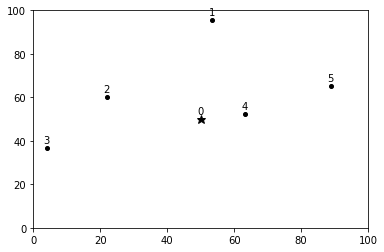

In [154]:
cust_x = field_width*np.random.random(num_cust) # x coordintes of all customers
cust_y = field_height*np.random.random(num_cust) # y coordinates of all customers
cust_dems = list(np.random.randint(dmin,dmax,num_cust)) # Uniformly distributed customer demands
xlocs = list(np.append([depot_x], cust_x)) # depot and customer x-coords
ylocs = list(np.append([depot_y], cust_y)) # depot and customer y-coords
demands = list(np.append([0], cust_dems)) # depot and customer demands
inst = Instance(xlocs, ylocs, demands)

plot_instance(inst, showLabels=True)

[0, 4, 2, 5, 1, 3]


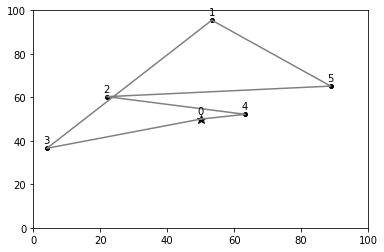

In [155]:
print(inst.tour)
plot_instance(inst, showTour=True, showLabels=True)

### 3) Print instance summary

In [151]:
print('--- INSTANCE SUMMARY ---')
print('Number of customers: \t', inst.size)
print('Vehicle capacity: \t', capacity)
print('Primary route size: \t', route_size)
print('Overlap size: \t\t', overlap_size)
print('Big TSP tour: \t\t', inst.tour[1:])
print('Tour demands: \t\t', [inst.demands[c] for c in inst.tour[1:]])
print('Lowerbound Cost: \t', int(inst.get_lowerbound(capacity)))

--- INSTANCE SUMMARY ---
Number of customers: 	 10
Vehicle capacity: 	 20
Primary route size: 	 5
Overlap size: 		 5
Big TSP tour: 		 [2, 1, 6, 9, 7, 8, 5, 4, 3, 10]
Tour demands: 		 [6, 6, 5, 0, 7, 2, 6, 7, 6, 5]
Lowerbound Cost: 	 221


### 4) Solve routing problem
#### a) Dedicated routing strategy
*The algorithm is described below:*
- Identify a single tour through all *N* customers.
- Split this sequence of *N* customers into into *M* "primary" route segments with equal number of customers ("route_size" or N' customers). This assumes *N* is divisible by *M*.
- Assign a single vehicle (with capacity *Q*) to each route.
- Get information on customers' updated (realized) demands
- Upon learning demands, vehicle *m* executes its primary route *m* in the following manner.
    - The vehicle departs from depot at full capacity.
    - It sequentially visits the customers in its primary route, skipping customers that have 0 demand.
    - Upon exhausting its capacity, the vehicle detours to the depot to refill to full capacity and resumes its route wherever it left off.
    - Upon filling all customer demands in the primary route, the vehicle has completed its route and returns to the depot.


In [30]:
print('--- DEDICATED ROUTING ---')
primary_routes = get_primary_routes(inst, route_size)
segments = create_full_trips(inst,primary_routes,capacity)
print('Big TSP tour: ', inst.tour[1:])
print('Tour demands: ', [inst.demands[c] for c in inst.tour[1:]])
print('\nA priori routes:', *primary_routes, sep="\n")
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', sum([get_radial_cost(inst,seg) for seg in segments]).round(1))
print('Circular cost:\t', sum([get_circular_cost(inst,seg) for seg in segments]).round(1))
print('Total cost:\t', sum([get_total_cost(inst,seg) for seg in segments]).round(1))

--- DEDICATED ROUTING ---
Big TSP tour:  [15, 12, 14, 19, 13, 2, 7, 18, 9, 4, 11, 20, 1, 17, 5, 3, 8, 10, 16, 6]
Tour demands:  [6, 3, 5, 3, 3, 6, 3, 2, 2, 6, 4, 3, 0, 2, 6, 3, 7, 3, 5, 6]

A priori routes:
[15, 12, 14, 19, 13]
[2, 7, 18, 9, 4]
[11, 20, 1, 17, 5]
[3, 8, 10, 16, 6]

Realized trips:
[15, 12, 14, 19, 13]
[2, 7, 18, 9, 4]
[11, 20, 17, 5]
[3, 8, 10, 16, 6]
[6]

Trip count:	 5
Radial cost:	 368.9
Circular cost:	 639.0
Total cost:	 1007.9


#### b) Overlapped routing strategy

*The algorithm is described below:*
- Create primary routes as described above in dedicated routing.
- Additionally, create extended routes by assigning each vehicle to all of the customers in its primary route plus some of the customers in a neighboring vehicle's primary route.
    - Extended routes formed under "full adjacent overlapping" means vehicle $m$ is assigned to customers in primary route $m$ plus all customers in primary route $m+1$, for vehicles $m=1,2,...,M-1$.
    - Alternatively, extended routes formed under "partial adjacent overlapping" means vehicle $m$ is assigned to customers in primary route $m$ plus $k$ additional customers in primary route $m+1$, for vehicles $m=1,2,...,M-1$.
    - In both cases, vehicle $m=M$ is assigned to only its primary route.
- Upon learning customer demands, vehicle *m* executes its extended route in the following manner.
    - The vehicle departs from depot at full capacity.
    - It sequentially visits the customers in its primary route, skipping customers that have 0 demand or demand that has already been filled. The vehicle reloads at the depot as needed.
    - Upon filling demand of the final customer in the primary route, the vehicle either (a) permanently returns to the depot if no capacity remains or (b) proceeds with the customers in the extended route and fills those customer demands until the leftover vehicle capacity is exhausted, at which point the vehicle permanently returns to the depot.
    - Vehicle *m+1* then starts primary route *m+1* wherever  vehicle *m* left off.
    - However, in the case that vehicle *m-1* satisfied the demand of ALL customers in the extended route (meaning it covered all demand in vehicle *m*'s primary route), then vehicle *m* is never deployed. Instead vehicle *m+1* just starts its route at the beginning of primary route *m+1*.

Note that a central planner assesses the realized customer demands and coordinate each vehicle's starting and ending customers (realized routes) within the extended route prior to the vehicle's departing the depot.

In [31]:
print('--- OVERLAPPED ROUTING (Based on Algorithm) ---')
primary_routes = get_primary_routes(inst, route_size)
extended_routes = get_extended_routes(inst, route_size, overlap_size)
segments = implement_k_overlapped_alg(inst,primary_routes,extended_routes,capacity,route_size,overlap_size)
combined = np.array([inst.tour[1:], [inst.demands[c] for c in inst.tour[1:]]])
print('Customers, Demand:')
print(combined)
#print('Big TSP tour: ', inst.tour[1:])
#print('Tour demands: ', [inst.demands[c] for c in inst.tour[1:]])
print('\nA priori routes:', *extended_routes, sep="\n")
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', sum([get_radial_cost(inst,seg) for seg in segments]).round(1))
print('Circular cost:\t', sum([get_circular_cost(inst,seg) for seg in segments]).round(1))
print('Total cost:\t', sum([get_total_cost(inst,seg) for seg in segments]).round(1))

--- OVERLAPPED ROUTING (Based on Algorithm) ---
Customers, Demand:
[[15 12 14 19 13  2  7 18  9  4 11 20  1 17  5  3  8 10 16  6]
 [ 6  3  5  3  3  6  3  2  2  6  4  3  0  2  6  3  7  3  5  6]]

A priori routes:
[15, 12, 14, 19, 13, 2, 7, 18, 9, 4]
[2, 7, 18, 9, 4, 11, 20, 1, 17, 5]
[11, 20, 1, 17, 5, 3, 8, 10, 16, 6]
[3, 8, 10, 16, 6]

Realized trips:
[15, 12, 14, 19, 13]
[2, 7, 18, 9, 4, 11]
[11, 20, 17, 5, 3, 8]
[8, 10, 16, 6]

Trip count:	 4
Radial cost:	 264.0
Circular cost:	 735.9
Total cost:	 999.8


In [32]:
print('--- CHECK: OVERLAPPED ROUTING (Alt. Method) ---')
print('Note: Implementation does not follow algorithm from paper')
extended_routes = get_extended_routes(inst, route_size, overlap_size)
segments = overlapping_check(inst,extended_routes,capacity,route_size,overlap_size)
print('Big TSP tour: ', inst.tour[1:])
print('Tour demands: ', [inst.demands[c] for c in inst.tour[1:]])
print('\nA priori routes:', *extended_routes, sep="\n")
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', sum([get_radial_cost(inst,seg) for seg in segments]).round(1))
print('Circular cost:\t', sum([get_circular_cost(inst,seg) for seg in segments]).round(1))
print('Total cost:\t', sum([get_total_cost(inst,seg) for seg in segments]).round(1))

--- CHECK: OVERLAPPED ROUTING (Alt. Method) ---
Note: Implementation does not follow algorithm from paper


NameError: name 'overlapping_check' is not defined

#### c) Fully flexible routing strategy

*The algorithm is described below:*
- As in the dedicated and overlapped routing strategies, create a large tour through all customers.
- Select a starting customer and send out a vehicle at full capacity to sequentially fill as much customer demand as possible.
- The vehicle returns to the depot upon exhuasting its capacity, and the next vehicle continues with the customer sequence where the previous vehicle left off.


Note that as in the overlapped routing strategies, demands are learned in advance, which means each truck's starting and ending customers can be determined prior to the day's deliveries so that vehicles can execute their realized routes simultaneously.

Also note that this strategy differs from full reoptimization since the sequence of customer visits within individul trips is fixed. In reoptimization, on the other hand, an individual vehicle trip can consists of any of the *N* customers.

In [33]:
print('--- FULLY FLEXIBLE ROUTING ---')
segments = create_full_trips(inst,[inst.tour[1:]],capacity)
print('Big TSP tour: ', inst.tour[1:])
print('Tour demands: ', [inst.demands[c] for c in inst.tour[1:]])
print('\nRealized trips:', *segments, sep="\n")
print('\nTrip count:\t', get_trip_count(segments))
print('Radial cost:\t', sum([get_radial_cost(inst,seg) for seg in segments]).round(1))
print('Circular cost:\t', sum([get_circular_cost(inst,seg) for seg in segments]).round(1))
print('Total cost:\t', sum([get_total_cost(inst,seg) for seg in segments]).round(1))

--- FULLY FLEXIBLE ROUTING ---
Big TSP tour:  [15, 12, 14, 19, 13, 2, 7, 18, 9, 4, 11, 20, 1, 17, 5, 3, 8, 10, 16, 6]
Tour demands:  [6, 3, 5, 3, 3, 6, 3, 2, 2, 6, 4, 3, 0, 2, 6, 3, 7, 3, 5, 6]

Realized trips:
[15, 12, 14, 19, 13]
[2, 7, 18, 9, 4, 11]
[11, 20, 17, 5, 3, 8]
[8, 10, 16, 6]

Trip count:	 4
Radial cost:	 264.0
Circular cost:	 735.9
Total cost:	 999.8


#### d) Reoptimization

In [152]:
print('--- SDVRP ---')
print('Total Cost: \t', solve_SDVRP(inst, capacity)[0])

--- SDVRP ---
Total Cost: 	 668
